# 5.3 - Predicción serie temporal

Usaré el modelo aditivo de [fbprophet](https://facebook.github.io/prophet/) para predecir la serie temporal de ocupación y precio medio por barrio.

In [1]:
# librerias
import pandas as pd
pd.options.plotting.backend = 'plotly'

from fbprophet import Prophet

In [2]:
listings=pd.read_csv('../data/raw_data/listings.csv.gz', 
                     compression='gzip', 
                     low_memory=False,
                     usecols=['id', 
                              'neighbourhood_cleansed', 
                              'neighbourhood_group_cleansed',
                              'latitude',
                              'longitude'])


listings.head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude
0,6369,Hispanoamérica,Chamartín,40.45628,-3.67763
1,21853,Cármenes,Latina,40.40341,-3.74084
2,23001,Legazpi,Arganzuela,40.38695,-3.69304
3,24805,Universidad,Centro,40.42202,-3.70395
4,24836,Justicia,Centro,40.41995,-3.69764


In [3]:
calendar=pd.read_csv('../data/raw_data/calendar.csv.gz', 
                     compression='gzip', 
                     low_memory=False,
                     usecols=['listing_id', 'available', 'date', 'price'])


calendar.head()

,listing_id,date,available,price
0,6369,2020-01-11,f,$80.00
1,96072,2020-01-11,f,$25.00
2,96072,2020-01-12,f,$25.00
3,96072,2020-01-13,f,$25.00
4,96072,2020-01-14,f,$25.00


In [4]:
def price_clean(x: str) -> float:
    
    """
    Esta función limpia una string, quitando $ y la coma y devuelve un float
    
    param x: string a limpiar
    
    return: float
    """
    try:
        x=x.replace('$', '').replace(',', '')
        return float(x)
    except:
        return float(x)

In [19]:
data=calendar.merge(listings, left_on='listing_id', right_on='id')

data.price=data.price.apply(price_clean)

data=data[(data.price>20) & (data.price<196)]

data=data[data.available=='f']


df=data.groupby(['date', 'neighbourhood_cleansed']).agg({'date': 'count', 'price': 'mean'})

df.columns=['count_', 'avg_price']
df.reset_index(inplace=True)
df.columns=['date', 'neighbourhood', 'count_', 'avg_price']

df.date=pd.to_datetime(df.date)

df.head()

,date,neighbourhood,count_,avg_price
0,2020-01-10,Abrantes,5,61.400000
1,2020-01-10,Acacias,44,50.500000
2,2020-01-10,Adelfas,11,57.454545
3,2020-01-10,Aeropuerto,2,27.500000
4,2020-01-10,Aguilas,9,46.222222


In [20]:
data.neighbourhood_cleansed.unique()

array(['Hispanoamérica', 'Cuatro Caminos', 'Universidad', 'Valverde',
       'Almenara', 'Guindalera', 'Embajadores', 'Pueblo Nuevo', 'Palacio',
       'Legazpi', 'Trafalgar', 'Almagro', 'Niño Jesús', 'Pilar', 'Sol',
       'Rios Rosas', 'Justicia', 'Pacífico', 'Acacias', 'Cortes',
       'Fuente del Berro', 'Los Angeles', 'Palos de Moguer', 'Arapiles',
       'Peñagrande', 'Piovera', 'Goya', 'Bellas Vistas', 'Casa de Campo',
       'Castellana', 'Recoletos', 'Puerta del Angel', 'Argüelles',
       'Puerta Bonita', 'Comillas', 'Canillas', 'San Isidro', 'Aluche',
       'Valdefuentes', 'Ibiza', 'Palomas', 'Jerónimos', 'Concepción',
       'Hellín', 'Delicias', 'Casco Histórico de Barajas',
       'Ciudad Jardín', 'San Fermín', 'Gaztambide', 'San Juan Bautista',
       'San Diego', 'Lucero', 'Rejas', 'Aravaca', 'Palomeras Bajas',
       'Prosperidad', 'Santa Eugenia', 'Salvador', 'Castilla', 'Lista',
       'Arcos', 'Castillejos', 'Casco Histórico de Vallecas',
       'Alameda de Osuna',

**Ejemplo Embajadores**

In [21]:
barrio=df[df.neighbourhood=='Embajadores']

barrio.head()

,date,neighbourhood,count_,avg_price
45,2020-01-10,Embajadores,341,67.445748
168,2020-01-11,Embajadores,2011,71.371457
295,2020-01-12,Embajadores,1651,61.988492
422,2020-01-13,Embajadores,1526,61.896461
548,2020-01-14,Embajadores,1504,61.965426


In [22]:
# seleccion para prophet y visualización de la serie

fb_data=barrio[['date', 'count_']].dropna()

fb_data.columns=['ds', 'y']

fig=fb_data.plot.scatter(x='ds', y='y')
fig.show();

In [23]:
%%time

modelo=Prophet(daily_seasonality=True, yearly_seasonality=True).fit(fb_data)

Initial log joint probability = -22.789
CPU times: user 51.5 ms, sys: 1.76 ms, total: 53.2 ms
Wall time: 53.2 ms
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       945.842    0.00383388       145.989      0.5926      0.5926      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       948.578   1.06104e-05       104.867      0.3216      0.3216      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       948.582   5.13545e-08       94.9983           1           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


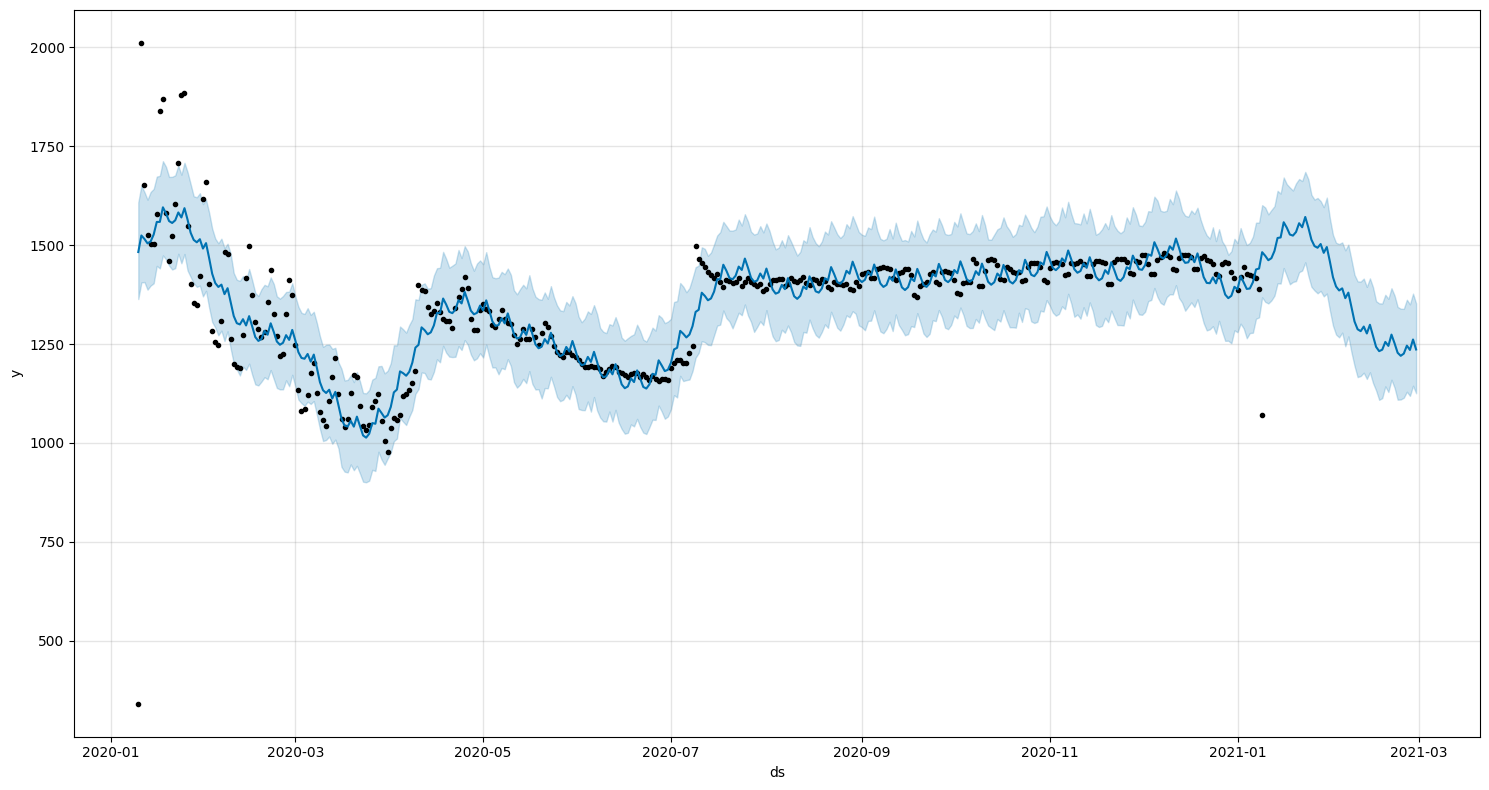

In [24]:
futuro=modelo.make_future_dataframe(periods=50, freq='D')   # 50 dias de prediccion

forecast=modelo.predict(futuro)

fig=modelo.plot(forecast, figsize=(15, 8))

In [25]:
fb_data=barrio[['date', 'avg_price']].dropna()

fb_data.columns=['ds', 'y']

fig=fb_data.plot.scatter(x='ds', y='y')
fig.show();

Initial log joint probability = -2.63897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1418.35   0.000176401        196.11           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1418.44   1.66996e-05       128.176   8.922e-08       0.001      214  LS failed, Hessian reset 
     199       1418.48   0.000210931       120.463           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       1418.53   3.36494e-05       212.391    2.82e-07       0.001      378  LS failed, Hessian reset 
     295       1418.55   6.07645e-08       102.132       0.245           1      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


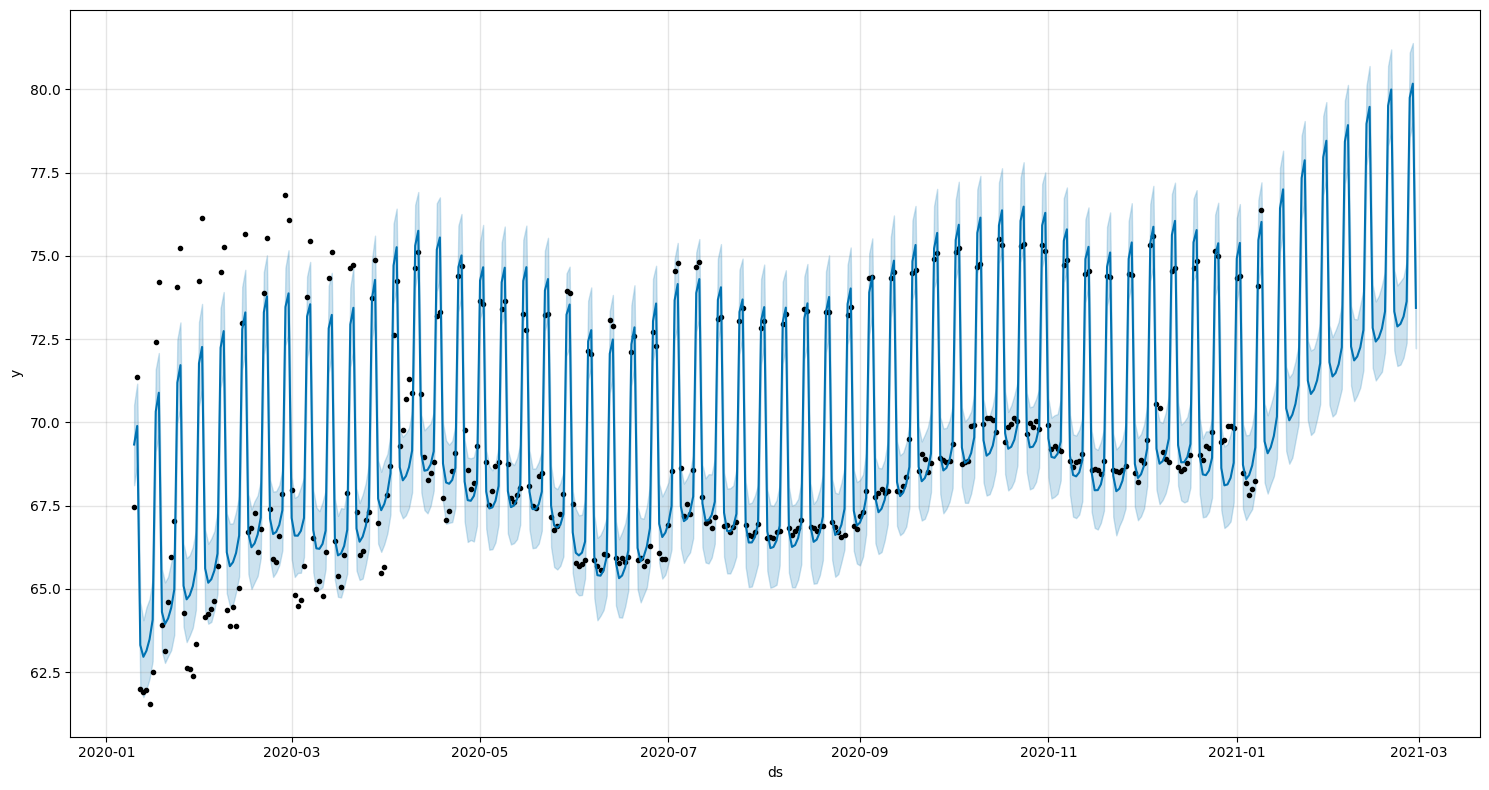

In [28]:
modelo=Prophet(daily_seasonality=True, yearly_seasonality=True).fit(fb_data)

futuro=modelo.make_future_dataframe(periods=50, freq='D')   # 50 dias de prediccion

forecast=modelo.predict(futuro)

fig=modelo.plot(forecast, figsize=(15, 8))